In [1]:
import random
from pathlib import Path
from collections import defaultdict
import itertools as it

import pandas as pd
import numpy as np

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from conjugate_normal import conjugate_normal

In [2]:
paths = list(Path("data/summaries").glob("*.csv"))
df = (
    pd
    .concat(
        [pd.read_csv(path) for path in paths],
        keys = [path.stem for path in paths]
    )[[
        "id",
        "page_slug",
        "user_id",
        "text",
        "isPassed",
        "containment_score",
        "similarity_score",
        "wording_score",
        "content_score",
        "created_at",
    ]]
    .drop_duplicates(subset=['text'])
    .dropna(subset=['content_score', 'page_slug'])
    .sort_values(by=["created_at"])
)

first_submissions = df.drop_duplicates(subset=["user_id", "page_slug"])

In [3]:
df.sample(3)

,,id,page_slug,user_id,text,isPassed,containment_score,similarity_score,wording_score,content_score,created_at
intro-computing,128,b69243c1-66b3-4959-823f-09825d6a43cd,conditionals,clst44w0c000583dntdn8hknn,Conditionals are structures that ask the compu...,True,0.0851,0.790603,0.445520,-0.083377,2024-02-19T18:26:48.236
poe,594,1175,7-2-labor-productivity-and-economic-growth,jg44hlfmmfvmurvxwzvteayakm,compound growth rates help to determine the mu...,False,0.1818,0.635610,NaN,-0.866801,2024-08-12 13:35:56.151425+00:00
intro-computing,1,c96b4003-76e3-4a2b-a87a-e019068badaf,conditionals,clsgxq96j000094onvvn671qc,Control structures help look for certain thing...,True,0.1579,0.768046,0.369943,-0.496748,2024-02-11T03:56:06.525


## Score Distributions

What does the distribution of scores look like by volume?

In [4]:
display(df.agg({
    "containment_score": ["count", "mean", "std"],
    "similarity_score": ["count", "mean", "std"],
    "wording_score": ["count", "mean", "std"],
    "content_score": ["count", "mean", "std"],
    })
)

display(df.groupby(level=0).agg({
    # "containment_score": ["count", "mean", "std"],
    # "similarity_score": ["mean", "std"],
    # "wording_score": ["mean", "std"],
    "content_score": ["count", "mean", "std", ("20%", lambda x : np.quantile(x, q=0.20))],
    })
)

display(first_submissions.groupby(level=0).agg({
    "content_score": ["count", "mean", "std", ("20%", lambda x : np.quantile(x, q=0.20))],
    })
)

,containment_score,similarity_score,wording_score,content_score
count,2884.000000,2884.000000,1766.000000,2884.000000
mean,0.082533,0.707036,0.247556,0.043284
std,0.230048,0.351523,0.479839,0.651009


content_score                              
                           count      mean       std       20%
business-law                 932 -0.242927  0.725733 -1.000000
intro-computing              460  0.010441  0.380371 -0.313237
learning-analytics           374  0.665977  0.339527  0.425964
poe                         1118  0.087086  0.596986 -0.313268

content_score                              
                           count      mean       std       20%
business-law                 688 -0.174132  0.775031 -1.000000
intro-computing              419  0.044310  0.362906 -0.248613
learning-analytics           339  0.684393  0.326035  0.475321
poe                          943  0.105934  0.612369 -0.306858

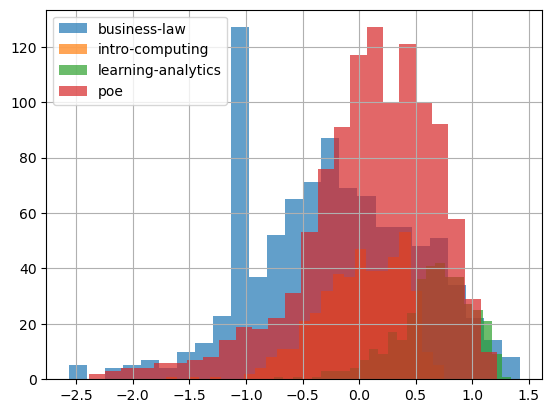

In [5]:
df["content_score"].groupby(level=0).hist(legend=True, bins=25, alpha=0.7);

## Score Distribution by Page

How much variation in scores between pages within a volume?

First need to get the page order by selecting a student who has completed all pages and extracting the order of their first submissions to each page.

In [70]:
def get_slug_sequence(data):
    # Find the first student who submitted a summary for all page_slugs (finished the volume)
    user_id = data.groupby(["user_id"])["page_slug"].count().sort_values(ascending=False).index[0]
    # Find the time-sorted sequence of page_slugs for that student
    submissions = data[data["user_id"] == user_id]
    slug_sequence = submissions.sort_values(by=["created_at"])["page_slug"]
    return slug_sequence
    
page_sequences = first_submissions.groupby(level=0).apply(get_slug_sequence).droplevel(1)
page_sequences.loc["poe"].to_list()

['7-1-the-relatively-recent-arrival-of-economic-growth',
 '7-2-labor-productivity-and-economic-growth',
 '7-3-components-of-economic-growth',
 '7-4-production-in-the-long-run']

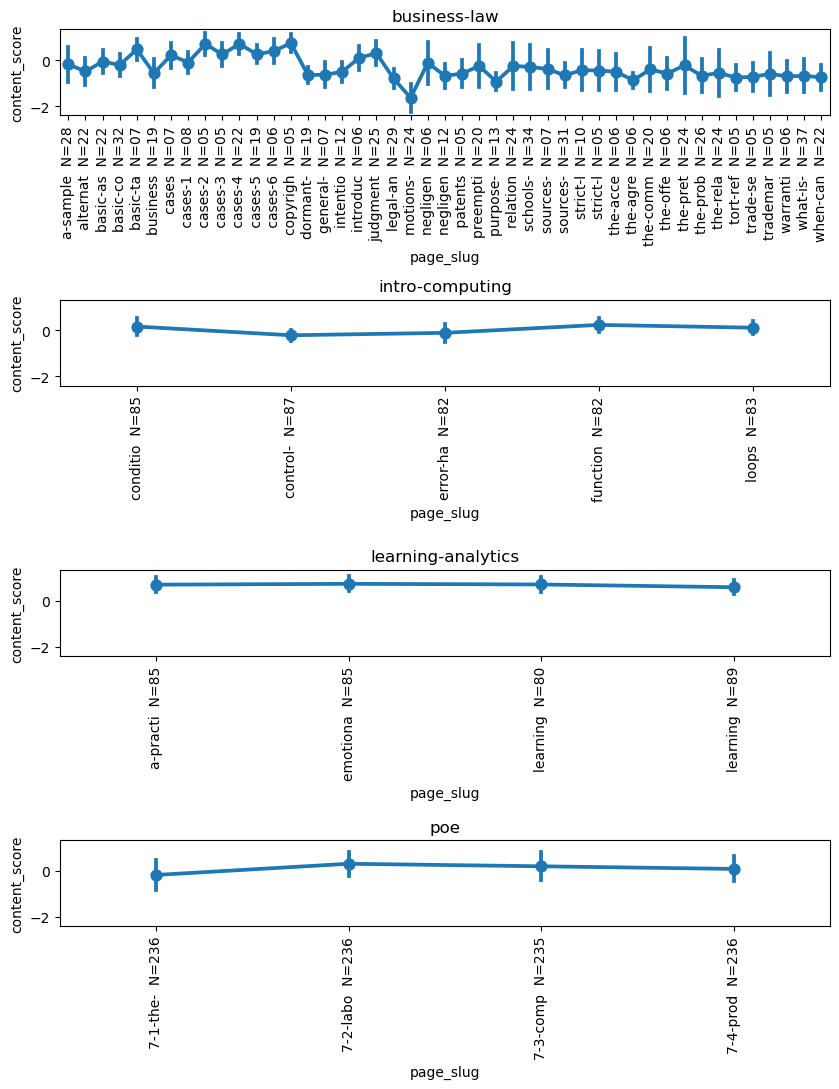

In [68]:
fig, axs = plt.subplots(4, sharey=True, figsize=(8.5,11))

for ax, (name, volume) in zip(axs, first_submissions.groupby(level=0)):
    sorter = page_sequences.loc[name].to_list()
    data = volume.sort_values(by=["page_slug"], key=lambda col: col.map(lambda e: sorter.index(e)))
    sns.pointplot(x=data.page_slug, y=data.content_score, ax=ax, errorbar="sd")
    ax.xaxis.set_ticks(data.page_slug.drop_duplicates())
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(name)
    ax.set_xticklabels([f"{k:>8.8}  N={len(v):02}" for k, v in data.groupby("page_slug")])

fig.tight_layout();

## Simulating the Bayesian Score Distributions

If we had used a Bayesian approach to estimate the scoring distribution over time during these deployments...

In [32]:
mu_global = 0.20
k_global = 15
alpha_global = 4
beta_global = 3.5

k_volume = 3

In [33]:
volumes = {}
students = {}
volume_updates = defaultdict(list)
student_updates = defaultdict(list)

start_threshold = conjugate_normal(mu_global, k_global, alpha_global, beta_global).threshold

for row in df.itertuples():
    volume_name = row.Index[0]
    if volume_name not in volumes:
        volumes[volume_name] = conjugate_normal(mu_global, k_global, alpha_global, beta_global)
    volume = volumes[volume_name]
    volume_updates[volume_name].append((volume.mu, volume.sigma, volume.threshold))
    volume.update([row.content_score])

    if row.user_id not in students:
        students[row.user_id] = conjugate_normal(volume.mu, k_volume, volume.alpha, volume.beta)
    student = students[row.user_id]
    student_updates[row.user_id].append((student.mu, student.sigma, student.threshold, row.content_score))
    student.update([row.content_score])

### By Volume

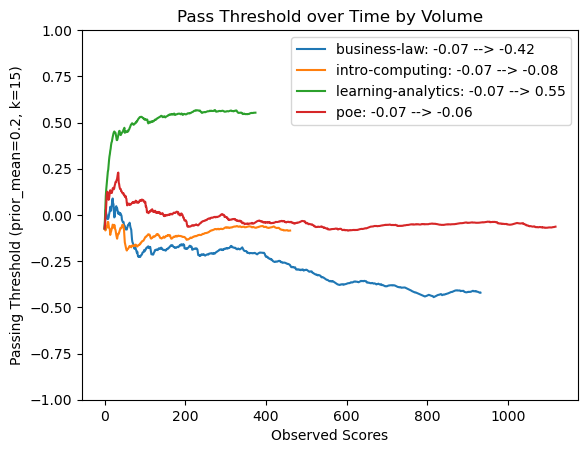

In [34]:
fig, ax = plt.subplots()
ax.set_ylim(-1, 1)

for volume_name, updates in volume_updates.items():
    arr = np.array(updates)
    means = arr[:,0]
    sigmas = arr[:,1]
    thresholds = arr[:,2]
    x = np.linspace(0, len(updates), len(updates))
    end_threshold = volumes[volume_name].threshold
    ax.plot(x, thresholds, label=f"{volume_name}: {start_threshold:.2f} --> {end_threshold:.2f}")    
    # ax.fill_between(x, means - sigmas, means + sigmas, alpha=0.05)
ax.set_title("Pass Threshold over Time by Volume")
ax.set_ylabel(f"Passing Threshold (prior_mean={mu_global}, k={k_global})")
ax.set_xlabel("Observed Scores")
ax.legend();

### By Student

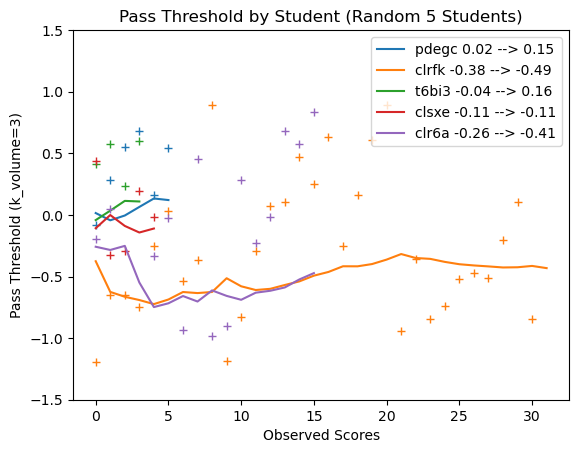

In [83]:
color_cycle = it.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
fig, ax = plt.subplots()
ax.set_ylim(-1.5, 1.5)

for student_id, updates in random.sample(list(student_updates.items()), 5):
    color = next(color_cycle)
    arr = np.array(updates)
    # means = arr[:,0]
    # sigmas = arr[:,1]
    thresholds = arr[:,2]
    scores = arr[:,3]
    x = np.arange(0, len(updates))
    end_threshold = students[student_id].threshold
    ax.plot(scores, "+", color=color)
    ax.plot(x, thresholds, label=f"{student_id:.5} {thresholds[0]:.2f} --> {end_threshold:.2f}", color=color)    
    # ax.fill_between(x, means - sigmas, means + sigmas, alpha=0.05)
ax.set_title("Pass Threshold by Student (Random 5 Students)")
ax.set_ylabel(f"Pass Threshold (k_volume={k_volume})")
ax.set_xlabel("Observed Scores")
# ax.legend(title=f"Starting Threshold={start_threshold:.2f}");
ax.legend();